In [1]:
import torch
import torchvision

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
print(torch.cuda.is_available())

False


In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [6]:
example_data.shape

torch.Size([1000, 1, 28, 28])

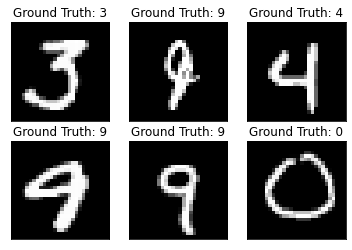

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap = 'gray', interpolation = 'none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
#fig

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  #1st 2-D convolutional layer
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) #2nd 2-D convolutional layer then dropout layer, drop some parameters for more simplified training
        x = x.view(-1, 320) #reshape tensor
        x = F.relu(self.fc1(x)) #linear layer
        x = F.dropout(x, training = self.training) #dropout layer
        x = self.fc2(x) #linear layer
        return F.log_softmax(x)

In [10]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr = learning_rate, momentum = momentum)
#SGD means stochastic gradient descent, SDG is a method which helps accelerate gradients vectors in the right directions
    #momentum is a moving average of our gradients

In [11]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

Train loop

In [12]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:  #print result every log_interval which is 10
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

Test loop

In [13]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [14]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/var/folders/8q/f7rs2g0j0mq74tdr9zrykwp00000gn/T/ipykernel_69212/3762209427.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/Users/Laptop/miniconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325928
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.287777
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.281435
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.243744
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.264606
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.240564
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.153203
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.211479
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.056642
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.010619
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.008978
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.867195
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.755029
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.617570
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.411560
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.595001
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.259282
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.326851
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.236279
Train Epoch: 1 [12160/6

Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.317382
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.438474
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.351770
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.352220
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.181803
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.448346
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.252764
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.287182
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.371310
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.409539
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.570453
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.333202
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.373962
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.547439
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.312928
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.377823
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.348830
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.377028
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.556540
Train Epoch: 2 [58240/60000 (97%)]	Loss: 0.109815


In [15]:
print(test_counter)
print(test_losses)

[0, 60000, 120000, 180000]
[2.30958232421875, 0.1856125503540039, 0.1192076904296875, 0.09096889572143554]


Plot the training curve

Text(0, 0.5, 'negative log likelihood loss')

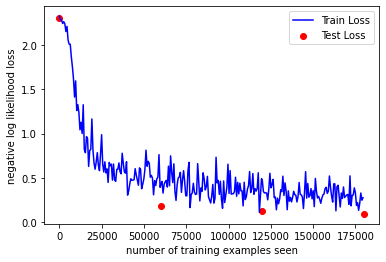

In [16]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
#fig

In [17]:
with torch.no_grad():
  output = network(example_data)

/var/folders/8q/f7rs2g0j0mq74tdr9zrykwp00000gn/T/ipykernel_69212/3762209427.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


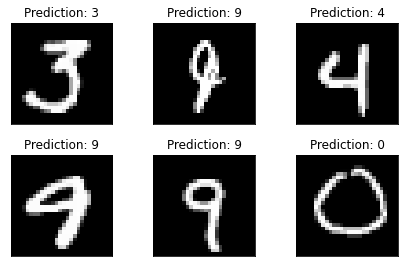

In [19]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
#fig

Continue training

In [20]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [24]:
network_state_dict = torch.load('./results/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('./results/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [25]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

/var/folders/8q/f7rs2g0j0mq74tdr9zrykwp00000gn/T/ipykernel_69212/3762209427.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.352513
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.274906
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.276132
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.189853
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.260861
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.217144
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.383878
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.394493
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.261398
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.176253
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.397133
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.288446
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.167478
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.180989
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.217887
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.207097
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.162772
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.115132
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.438580
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.218959
Train Epoch: 4 [12800/60000 (

Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.272950
Train Epoch: 5 [45440/60000 (76%)]	Loss: 0.168207
Train Epoch: 5 [46080/60000 (77%)]	Loss: 0.415719
Train Epoch: 5 [46720/60000 (78%)]	Loss: 0.185303
Train Epoch: 5 [47360/60000 (79%)]	Loss: 0.282721
Train Epoch: 5 [48000/60000 (80%)]	Loss: 0.259022
Train Epoch: 5 [48640/60000 (81%)]	Loss: 0.237348
Train Epoch: 5 [49280/60000 (82%)]	Loss: 0.412195
Train Epoch: 5 [49920/60000 (83%)]	Loss: 0.160395
Train Epoch: 5 [50560/60000 (84%)]	Loss: 0.416583
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.163749
Train Epoch: 5 [51840/60000 (86%)]	Loss: 0.271112
Train Epoch: 5 [52480/60000 (87%)]	Loss: 0.174831
Train Epoch: 5 [53120/60000 (88%)]	Loss: 0.103489
Train Epoch: 5 [53760/60000 (90%)]	Loss: 0.244693
Train Epoch: 5 [54400/60000 (91%)]	Loss: 0.125972
Train Epoch: 5 [55040/60000 (92%)]	Loss: 0.202122
Train Epoch: 5 [55680/60000 (93%)]	Loss: 0.190855
Train Epoch: 5 [56320/60000 (94%)]	Loss: 0.105592
Train Epoch: 5 [56960/60000 (95%)]	Loss: 0.239605


Train Epoch: 7 [29440/60000 (49%)]	Loss: 0.444582
Train Epoch: 7 [30080/60000 (50%)]	Loss: 0.128969
Train Epoch: 7 [30720/60000 (51%)]	Loss: 0.189950
Train Epoch: 7 [31360/60000 (52%)]	Loss: 0.148691
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.167202
Train Epoch: 7 [32640/60000 (54%)]	Loss: 0.432472
Train Epoch: 7 [33280/60000 (55%)]	Loss: 0.199567
Train Epoch: 7 [33920/60000 (57%)]	Loss: 0.291578
Train Epoch: 7 [34560/60000 (58%)]	Loss: 0.411831
Train Epoch: 7 [35200/60000 (59%)]	Loss: 0.149413
Train Epoch: 7 [35840/60000 (60%)]	Loss: 0.307633
Train Epoch: 7 [36480/60000 (61%)]	Loss: 0.140103
Train Epoch: 7 [37120/60000 (62%)]	Loss: 0.119098
Train Epoch: 7 [37760/60000 (63%)]	Loss: 0.132531
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.148705
Train Epoch: 7 [39040/60000 (65%)]	Loss: 0.180289
Train Epoch: 7 [39680/60000 (66%)]	Loss: 0.257234
Train Epoch: 7 [40320/60000 (67%)]	Loss: 0.260444
Train Epoch: 7 [40960/60000 (68%)]	Loss: 0.079426
Train Epoch: 7 [41600/60000 (69%)]	Loss: 0.088259


Text(0, 0.5, 'negative log likelihood loss')

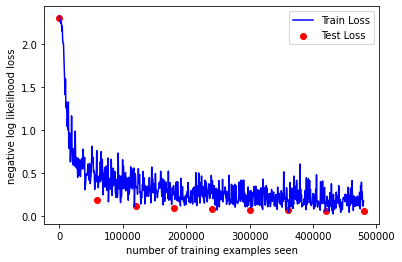

In [26]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
#fig